--- 1. Criando/Verificando a estrutura do banco de dados... ---
[OK] Estrutura do banco de dados pronta.

--- 2. Coletando dados da API e inserindo no banco de dados... ---
  [OK] Dados para 2024-10-07 inseridos. Taxa: 5.4380
  [OK] Dados para 2024-10-08 inseridos. Taxa: 5.5116
  [OK] Dados para 2024-10-09 inseridos. Taxa: 5.5438
  [OK] Dados para 2024-10-10 inseridos. Taxa: 5.5855
  [OK] Dados para 2024-10-11 inseridos. Taxa: 5.5665
  [OK] Dados para 2024-10-12 inseridos. Taxa: 5.5665
  [OK] Dados para 2024-10-13 inseridos. Taxa: 5.5665
  [OK] Dados para 2024-10-14 inseridos. Taxa: 5.6292
  [OK] Dados para 2024-10-15 inseridos. Taxa: 5.5901
  [OK] Dados para 2024-10-16 inseridos. Taxa: 5.6375
  [OK] Dados para 2024-10-17 inseridos. Taxa: 5.6828
  [OK] Dados para 2024-10-18 inseridos. Taxa: 5.6539
  [OK] Dados para 2024-10-19 inseridos. Taxa: 5.6539
  [OK] Dados para 2024-10-20 inseridos. Taxa: 5.6539
  [OK] Dados para 2024-10-21 inseridos. Taxa: 5.7084
  [OK] Dados para 2024-10-22 ins

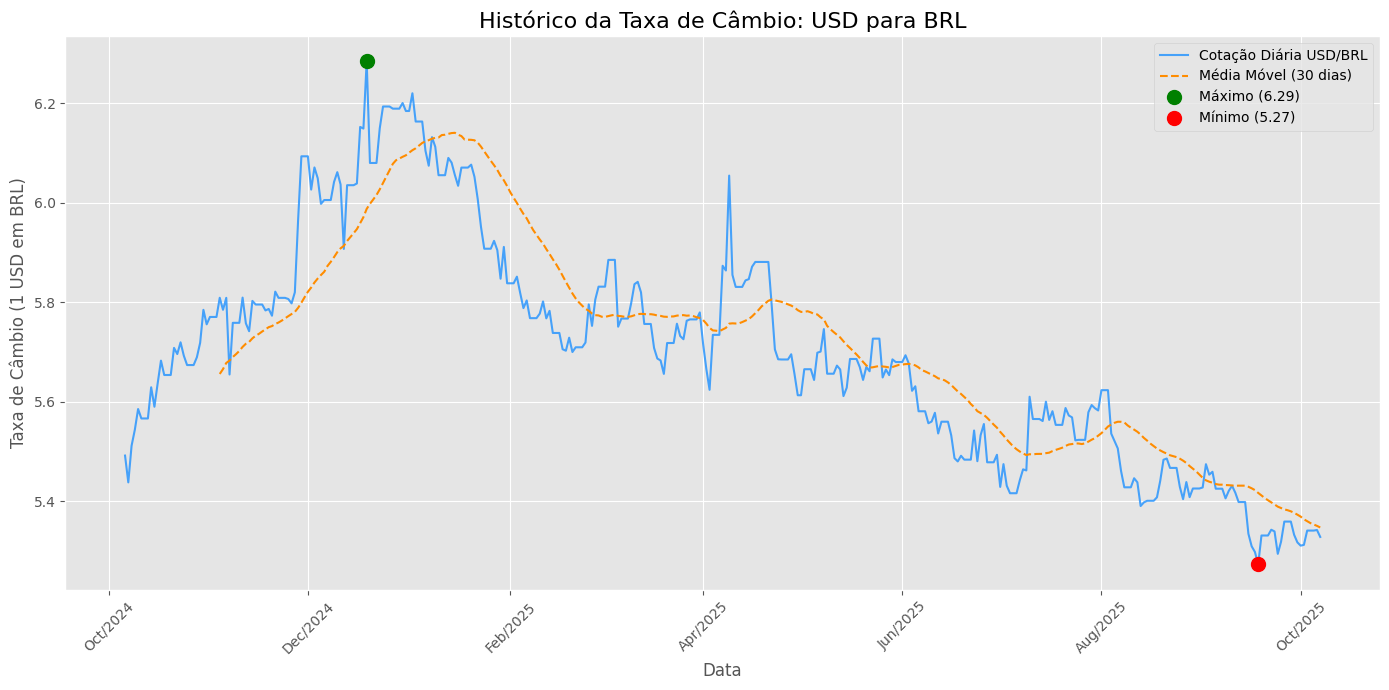


--- 5. Processo concluído e conexão com o banco de dados fechada. ---


In [ ]:
import sqlite3
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# ==============================================================================
#  CONFIGURAÇÃO INICIAL
# ==============================================================================

API_URL = "https://api.frankfurter.app"
DB_NOME = 'cambio_historico.db'
MOEDA_BASE = 'USD'
MOEDA_ALVO = 'BRL'

# Período de 1 ano de dados históricos
DATA_FIM = datetime.now()
DATA_INICIO = DATA_FIM - timedelta(days=365)

# Conexão com o banco de dados sqlite3
conn = sqlite3.connect(DB_NOME)
cursor = conn.cursor()

# ==============================================================================
#  ESTRUTURA DO BANCO DE DADOS (SQL)
# ==============================================================================
print(" 1. Criando/Verificando a estrutura do banco de dados... ")
cursor.execute("""
    CREATE TABLE IF NOT EXISTS TaxasCambio (
        id INTEGER PRIMARY KEY,
        data TEXT NOT NULL,
        moeda_base TEXT NOT NULL,
        moeda_alvo TEXT NOT NULL,
        taxa REAL NOT NULL,
        UNIQUE(data, moeda_base, moeda_alvo)
    );
""")
conn.commit()
print("[OK] Estrutura do banco de dados pronta.")

# ==============================================================================
#  COLETA DE DADOS VIA API E INSERÇÃO NO SQL
# ==============================================================================
print("\n--- 2. Coletando dados da API e inserindo no banco de dados... ---")

# Define o intervalo de datos que irá ser realizado a busca
datas_para_buscar = pd.date_range(start=DATA_INICIO, end=DATA_FIM, freq='D')

for data in datas_para_buscar:
    data_str = data.strftime('%Y-%m-%d')
    
    # Url especifica para a API
    url_completa = f"{API_URL}/{data_str}?from={MOEDA_BASE}&to={MOEDA_ALVO}"
    
    try:
        # Requisição para a API
        response = requests.get(url_completa)
        response.raise_for_status()  # Lança um erro para respostas HTTP ruins (4xx ou 5xx)
        
        # Extrai os dados do JSON
        dados_api = response.json()
        taxa = dados_api['rates'][MOEDA_ALVO]
        
        # Insere os dados no banco de dados
        sql_insert = """
            INSERT OR IGNORE INTO TaxasCambio (data, moeda_base, moeda_alvo, taxa)
            VALUES (?, ?, ?, ?);
        """
        cursor.execute(sql_insert, (data_str, MOEDA_BASE, MOEDA_ALVO, taxa))
        
        print(f"  [OK] Dados para {data_str} inseridos. Taxa: {taxa:.4f}")

    except requests.exceptions.RequestException as e:
        print(f"  [ERRO] Falha na requisição para {data_str}: {e}")
    except KeyError:
        # A API pode não ter dados para fins de semana ou feriados (Não esquecer)
        print(f"  [AVISO] Sem dados de câmbio para {data_str} (provavelmente fim de semana/feriado).")
    except Exception as e:
        print(f"  [ERRO] Ocorreu um erro inesperado para {data_str}: {e}")

# Salva todas as inserções no banco de dados
conn.commit()
print("[OK] Coleta de dados finalizada.")

# ==============================================================================
#  CONSULTA SQL E ANÁLISE DE DADOS COM PANDAS
# ==============================================================================
print("\n--- 3. Carregando dados do SQL e realizando a análise... ---")

sql_select = f"""
    SELECT data, taxa
    FROM TaxasCambio
    WHERE moeda_base = '{MOEDA_BASE}' AND moeda_alvo = '{MOEDA_ALVO}'
    ORDER BY data;
"""

# parse_dates converte a coluna de texto 'data' para o tipo datetime
# index_col define a coluna 'data' como o índice do DataFrame
df = pd.read_sql_query(sql_select, conn, parse_dates=['data'], index_col='data')

if not df.empty:
    
    print("\nAnálise Descritiva da Taxa de Câmbio:")
    print(df['taxa'].describe())

    
    valor_maximo = df['taxa'].max()
    data_maximo = df['taxa'].idxmax().strftime('%d/%m/%Y')
    valor_minimo = df['taxa'].min()
    data_minimo = df['taxa'].idxmin().strftime('%d/%m/%Y')
    
    print(f"\n- Maior cotação: {valor_maximo:.4f} em {data_maximo}")
    print(f"- Menor cotação: {valor_minimo:.4f} em {data_minimo}")

   

    df['media_movel_30d'] = df['taxa'].rolling(window=30).mean()
    
    print("[OK] Análise concluída.")
    
    # ==============================================================================
    #  VISUALIZAÇÃO DOS DADOS
    # ==============================================================================
    print("\n--- 4. Gerando visualização gráfica... ---")

    plt.style.use('ggplot') 
    fig, ax = plt.subplots(figsize=(14, 7)) # figura e os eixos do gráfico

    # Plota a taxa de câmbio diária
    ax.plot(df.index, df['taxa'], label=f'Cotação Diária {MOEDA_BASE}/{MOEDA_ALVO}', color='dodgerblue', alpha=0.8)
    
    # Plota a média móvel
    ax.plot(df.index, df['media_movel_30d'], label='Média Móvel (30 dias)', color='darkorange', linestyle='--')
    
    # Adiciona marcadores para os pontos de máximo e mínimo
    ax.plot(df['taxa'].idxmax(), valor_maximo, 'go', markersize=10, label=f'Máximo ({valor_maximo:.2f})')
    ax.plot(df['taxa'].idxmin(), valor_minimo, 'ro', markersize=10, label=f'Mínimo ({valor_minimo:.2f})')

    # Configurações do gráfico para melhor visualização
    ax.set_title(f'Histórico da Taxa de Câmbio: {MOEDA_BASE} para {MOEDA_ALVO}', fontsize=16)
    ax.set_xlabel('Data', fontsize=12)
    ax.set_ylabel(f'Taxa de Câmbio (1 {MOEDA_BASE} em {MOEDA_ALVO})', fontsize=12)
    ax.legend(fontsize=10)
    
    # Formatação do eixo de datas para ficar mais legível
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
    plt.xticks(rotation=45)
    
    plt.tight_layout() 
    plt.show()

else:
    print("\n[AVISO] Nenhum dado foi encontrado no banco de dados para gerar a análise e o gráfico.")

# ==============================================================================
# 6. ENCERRAMENTO
# ==============================================================================
# Fecha a conexão com o banco de dados
conn.close()
print("\n--- 5. Processo concluído e conexão com o banco de dados fechada. ---") 